In [4]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
from os.path import join as oj
import data
import matplotlib.pyplot as plt
import seaborn as sns
import config
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# extract the relevant model

In [7]:
r = data.load_fitted_results(fname_filters=['bert-base', 'sub=-1'], dset_filters=['sst2'])
row = r[(r.checkpoint == 'textattack/bert-base-uncased-SST-2') & (r.ngrams == 2)].iloc[0]

100%|██████████| 12/12 [00:00<00:00, 715.03it/s]


# find ngrams

In [3]:
nlp = English()
simple_tokenizer = nlp.tokenizer # for our word-finding
simple_tokenizer = lambda x: [str(x) for x in nlp.tokenizer(x)] # for our word-finding

In [4]:
dataset = datasets.load_dataset('sst2')
vectorizer = CountVectorizer(tokenizer=simple_tokenizer, ngram_range=(1, row.ngrams))
vectorizer.fit(dataset['train']['sentence'])
vocab_counts = vectorizer.vocabulary_

Using custom data configuration default
Reusing dataset sst2 (/tmp/.xdg_cache_vision/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

/accounts/projects/vision/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


# feed through model

In [11]:
tokenizer = AutoTokenizer.from_pretrained(row.checkpoint) # for actually passing things to the model
model = BertModel.from_pretrained(row.checkpoint)
logistic = row.model

Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
seqs_all = sorted(vocab_counts.keys())

In [19]:
n = 300
seqs = np.array(seqs_all)[np.random.choice(len(seqs_all), size=n, replace=False)].tolist()
tokens = tokenizer(seqs, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens) # has two keys, 'last_hidden_state', 'pooler_output'
embs = output['pooler_output'].cpu().detach().numpy()

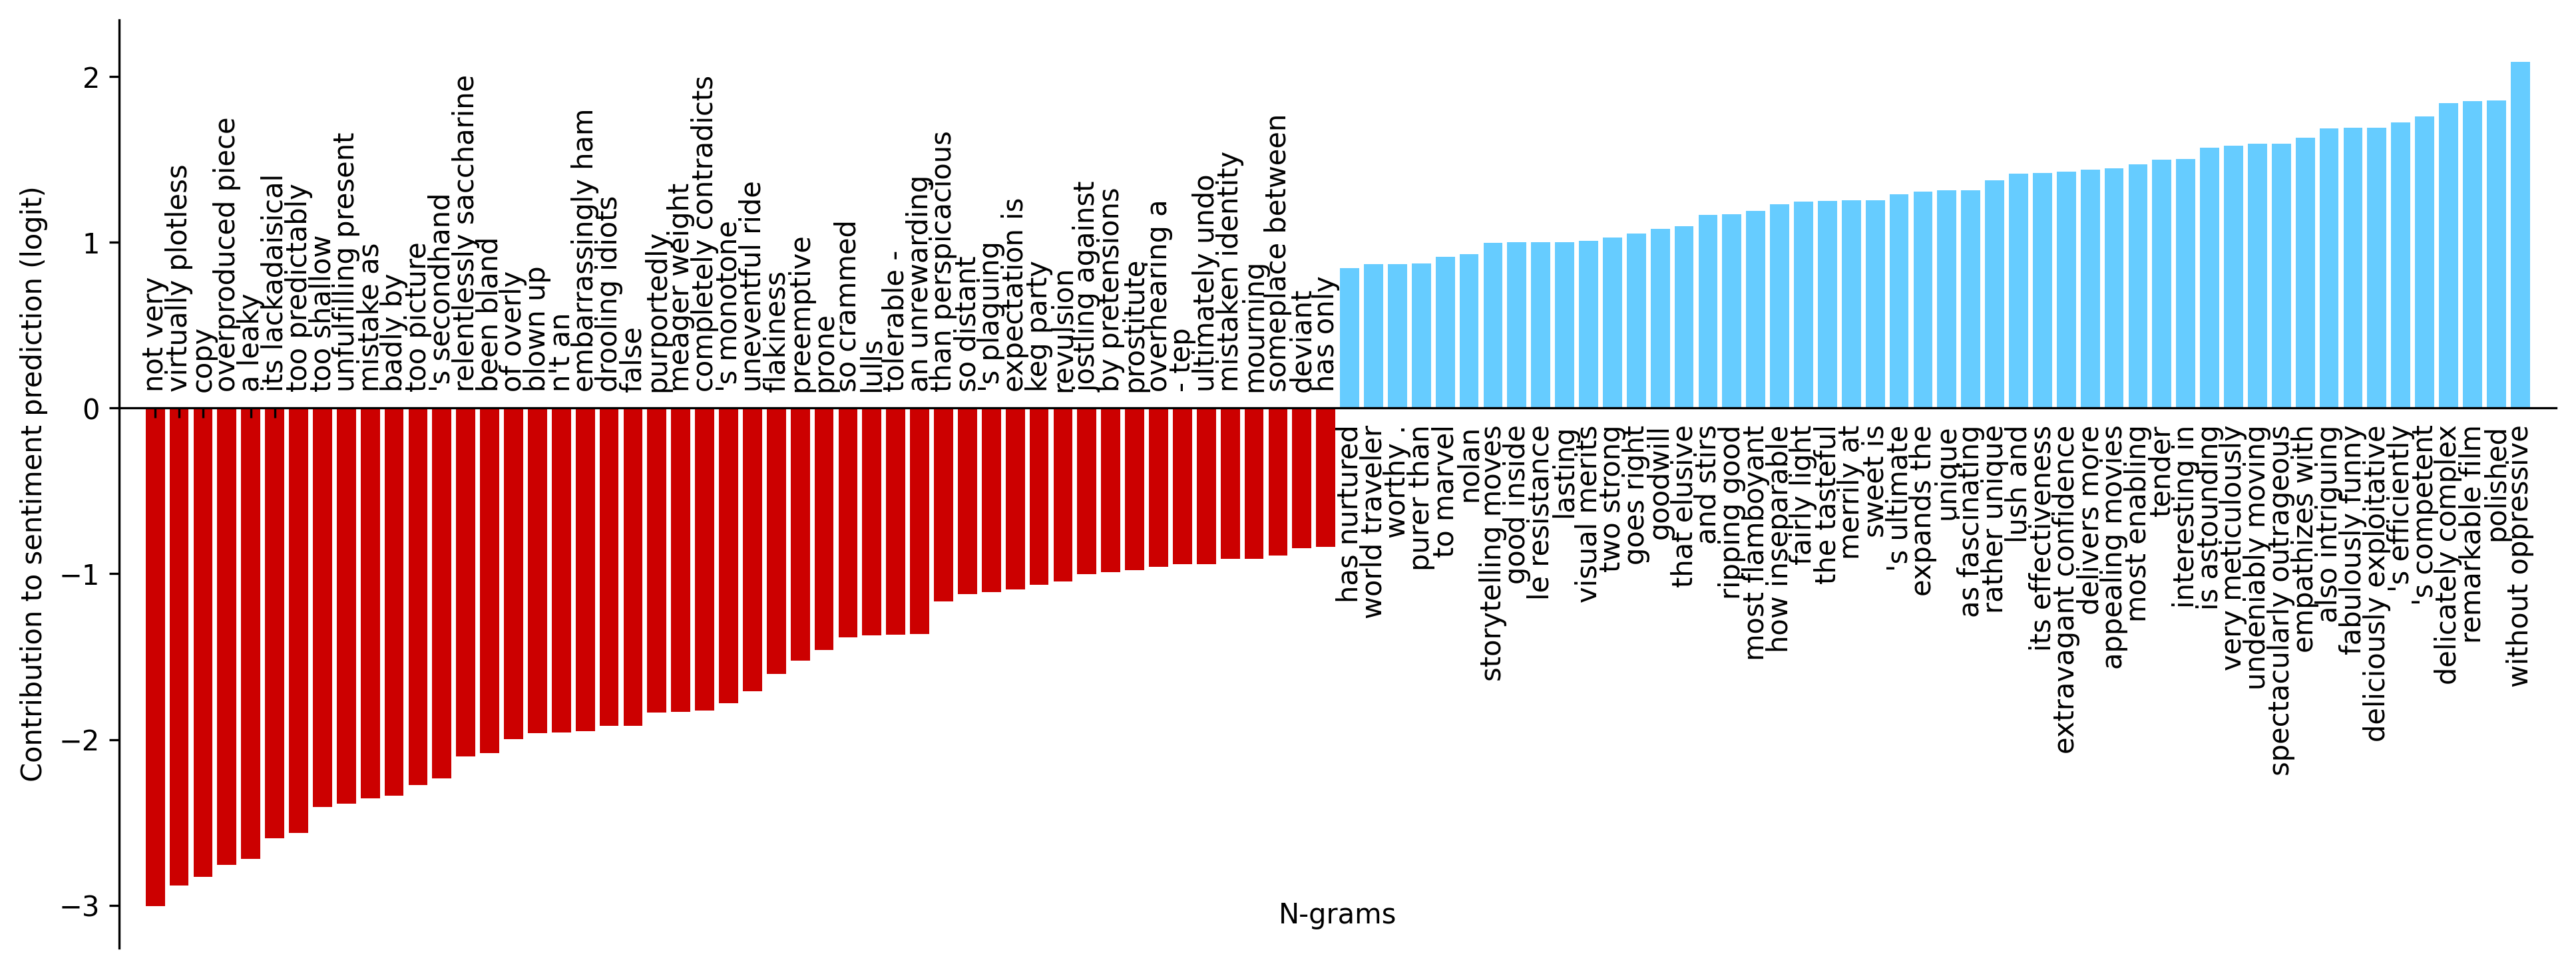

In [66]:
logits = embs @ logistic.coef_.squeeze() # + logistic.intercept_
num_top = 50
args = np.argsort(logits)
args = np.concatenate((args[:num_top], args[-num_top:]))

fig, ax = plt.subplots(dpi=300, figsize=(13, 5))

x = np.arange(args.size)
y = logits[args]
labels = np.array(seqs)[args].astype(str).tolist()
p1 = ax.bar(x=x, height=y,
       color=[dvu.cr] * num_top + [dvu.cb] * num_top)

ax.set_xticklabels([])
# remove the extra tick on the negative bar
ax.set_xticks([idx for (idx, x) in enumerate(performance) if x > 0])
ax.spines["bottom"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


label_offset = 0.1
for label, (x_position, y_position) in zip(labels, enumerate(y)):
    if y_position > 0:
        label_y = -label_offset
        ax.text(x_position, label_y, label, ha="center", va="top", rotation=90)
    else:
        label_y = +label_offset
        ax.text(x_position, label_y, label, ha="center", va="bottom", rotation=90)
# Placing the x-axis label, note the transformation into `Axes` co-ordinates
# previously data co-ordinates for the x ticklabels
ax.text(0.5, 0.05, "N-grams", ha="center", va="top", transform=ax.transAxes)
plt.ylabel('Contribution to sentiment prediction (logit)')
plt.xlim([-1.5 , x.size + 0.5])
plt.tight_layout()
plt.savefig('results/n-gram-contribution.pdf')
plt.show()

# look at some new ngrams